# Iceland KH-9 Panoramic Camera preprocessing

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
import hipp
import usgsxplore
import os
from pathlib import Path
import rasterio

## Settings

In [18]:
# path settings
paths: dict[str, Path] = {}
dir = Path("/mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22")

paths["dir"] = dir
paths["raw_images"] = Path("/mnt/summer/USERS/DEHECQA/history/data_final/iceland/kh9_pc_images/1980_08_22/raw_images")
paths["preproc_images"] = dir / "preprocessed_images"
paths["joined_images"] = dir / "joined_images"
paths["qc"] = dir / "qc"
paths["intrinsics"] = dir / "camera_model_intrinsics.csv"
paths["extrinsics"] = dir / "camera_model_extrinsics.csv"
paths["footprint"] = dir / "images_footprint.geojson"

# others settings
QUICKVIEWS_FACTOR = 0.05
MAX_WORKERS = 4
OVERWRITE = False

os.environ["USGS_USERNAME"] = "godinlu"
os.environ["USGS_TOKEN"] = "5guA_wc6vdbB5aI8!5MrMBbyWX3iMH4xZ2e09czmQbbK0h9rBTQVkxPg1fswwTUW"

## Downloading the dataset

| Dataset Name | Date | Images Count | Preprocess Notebook | Raw images acces| Preprocessed images size | Raw images size|
|--|--|--|--|--|--|--|
| Casa Grande KH-9 PC | 1978/03/25 | 6 |here| USGS | 43 Go | 47 Go |


In [6]:
dataset = "declassiii"
entity_ids = ["D3C1216-200533A021", "D3C1216-200533A022", "D3C1216-200533A023", "D3C1216-200533F021", "D3C1216-200533F022", "D3C1216-200533F023"]

if not paths["raw_images"].exists() or not paths["footprint"].exists() or not paths["extrinsics"].exists() or OVERWRITE:
    username = os.getenv("USGS_USERNAME") or input("Enter your USGS username: ")
    token = os.getenv("USGS_TOKEN") or input("Enter your USGS token: ")

    # connect to the API
    api = usgsxplore.API(username, token)

    # get metadata of scenes with their ids
    scenes_metadata = api.get_scenes_metadata(dataset, entity_ids)

    # save the footprint files
    usgsxplore.utils.convert_response_to_gdf(scenes_metadata).to_file(paths["footprint"], driver="GeoJSON")

    # Process metadata to save the extrinsics file
    df = usgsxplore.utils.convert_response_to_df(scenes_metadata)
    df["image_file_name"] = df["Entity ID"].apply(lambda txt: f"{txt}.tif")
    df["lat"] = df["Center Latitude dec"]
    df["lon"] = df["Center Longitude dec"]
    df["alt"] = 160000 
    df[["image_file_name", "lon", "lat", "alt"]].to_csv(paths["extrinsics"], index=False)

    # download raw images
    api.download(dataset, entity_ids, output_dir=paths["raw_images"], overwrite=OVERWRITE)

    api.logout()

    hipp.tools.generate_quickviews(paths["raw_images"], QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

## Create the camera intrinsics file

In [19]:
hipp.Intrinsics(focal_length=1524, pixel_pitch=0.007).to_csv(paths["intrinsics"])

## Step 2 : Joining Images

The first step of the preprocessing pipeline is to **join multiple image tiles** into a single, continuous image. This process is necessary because **KH9 PC images are typically split into 10-12 separate parts**, each approximately **1 GB in size**, due to their large original resolution.

However, **joining these image parts is not straightforward**, primarily because there is a **slight overlap between adjacent tiles**. 

To accurately reconstruct the full image, we need to perform the following steps:

1. **Detect keypoints (interest points)** along the **right border** of the first image part.
2. Detect corresponding keypoints along the **left border** of the next image part.
3. **Match these keypoints** using a feature-matching algorithm to find candidate correspondences.
4. Use **RANSAC (Random Sample Consensus)** to filter out mismatched or erroneous correspondences (i.e., outliers).
5. Estimate a **relative geometric transformation** (typically a translation or affine transform) to correctly align the second image with the first.
6. Apply this transformation and **merge the two parts** into a larger composite image.

This process is repeated sequentially for all image parts, progressively building up the full image mosaic.

To perform that 2 functions exists:
- `join_images_asp` (recommanded) : which will use [`image_mosaic`](https://stereopipeline.readthedocs.io/en/latest/tools/image_mosaic.html) program from Ames Stereo Pipeline. This function is much more safer but it requiered to install ASP and the command need to be visible in your path.
- `join_images` (beta) : is a pure Python implementation that replicates the same processing steps, but currently lacks blending in overlapping regions.


In [8]:
# this version use image_mosaic from asp, So you need to have asp in your path
#hipp.kh9pc.join_images_asp(paths["raw_images"], paths["joined_images"])

hipp.kh9pc.join_images(paths["raw_images"], paths["joined_images"], OVERWRITE, max_workers=MAX_WORKERS)

hipp.tools.generate_quickviews(paths["joined_images"], QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

Skipping /mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533A021.tif: output already exists
Skipping /mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533A022.tif: output already exists
Skipping /mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533A023.tif: output already exists
Skipping /mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533F021.tif: output already exists
Skipping /mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533F022.tif: output already exists
Skipping /mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533F023.tif: output already exists


In [ ]:
for raster_filepath in paths["joined_images"].glob("*.tif"):
    output_raster_filepath = paths["preproc_images"] / raster_filepath.name

    # don't overwrite
    if not output_raster_filepath.exists():
        print(f"Processing : {raster_filepath.name}...")

        
        # Detect collimation lines
        print("Estimation of collimation lines...")
        output_plot_path = paths["qc"] / "collimation_lines" / f"{raster_filepath.stem}.png"
        collimation_lines = hipp.kh9pc.lines_processing.detect_horizontal_collimation_lines(raster_filepath, plot=False, output_plot_path=output_plot_path)

        # Detect vertical edges
        print("Detection of vertical edges...")
        output_plot_path = paths["qc"] / "vertical_edges" / f"{raster_filepath.stem}.png"
        vertical_edges = hipp.kh9pc.lines_processing.detect_vertical_edges(raster_filepath, plot=False, output_plot_path=output_plot_path)
        
        # Plot the distance between collimation lines
        output_plot_path = paths["qc"] / "distance_between_collimation_lines" / f"{raster_filepath.stem}.png"
        hipp.kh9pc.lines_processing.plot_distance_between_collimation_lines(vertical_edges, collimation_lines, plot=False, output_plot_path=output_plot_path)

        # compute the transformation
        output_plot_path = paths["qc"] / "transformations" / f"{raster_filepath.stem}.png"
        tf_matrix, output_img_size, dists = hipp.kh9pc.lines_processing.compute_transformation(vertical_edges, collimation_lines, plot=False, output_plot_path=output_plot_path)

        # Warp the image
        print(f"Warping {raster_filepath} -> {output_raster_filepath}")
        hipp.image.warp_raster_pixels(raster_filepath, output_raster_filepath, tf_matrix, output_img_size)

        # detect collimation lines after transform
        print("Estimation of collimation lines after transformation...")
        output_plot_path = paths["qc"] / "collimation_lines_after_transform" / f"{output_raster_filepath.stem}.png"
        padding = (0,0) # set the padding to (0,0) because the output image is cropped
        collimation_lines = hipp.kh9pc.lines_processing.detect_horizontal_collimation_lines(output_raster_filepath, padding, plot=False, output_plot_path=output_plot_path)

        # Plot the distance between collimation lines after transformation
        with rasterio.open(output_raster_filepath) as src:
            vertical_edges = {"left":0, "right": src.width}
        output_plot_path = paths["qc"] / "distance_between_collimation_lines_after_transform" / f"{output_raster_filepath.stem}.png"
        hipp.kh9pc.lines_processing.plot_distance_between_collimation_lines(vertical_edges, collimation_lines, plot=False, output_plot_path=output_plot_path)


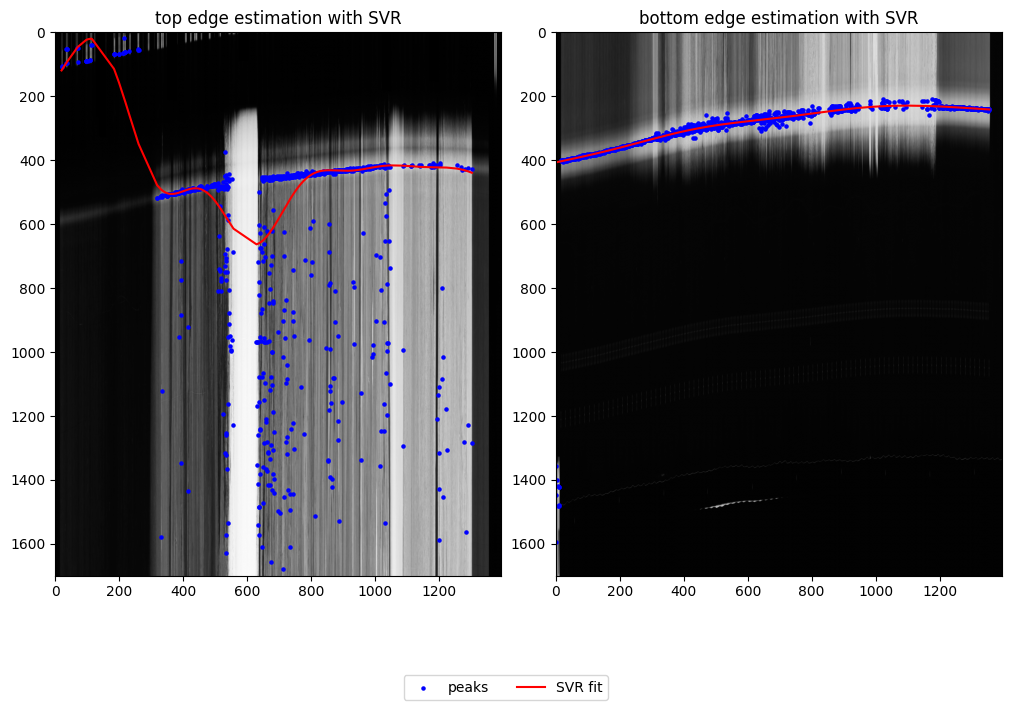

In [ ]:
raster_filepath = sorted(paths["joined_images"].glob("*.tif"))[1]
collimation_lines = hipp.kh9pc.lines_processing.detect_horizontal_collimation_lines(raster_filepath,peaks_prominence=20,svr_C=1000, peaks_height=None, peaks_width=30)

In [34]:
band, offset = hipp.kh9pc.lines_processing.extract_raster_band_slice(raster_filepath, stride=256, side="top", padding=(0, 700))



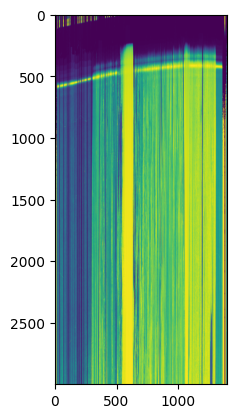

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import cv2

cv2.normalize()

In [ ]:
plt.

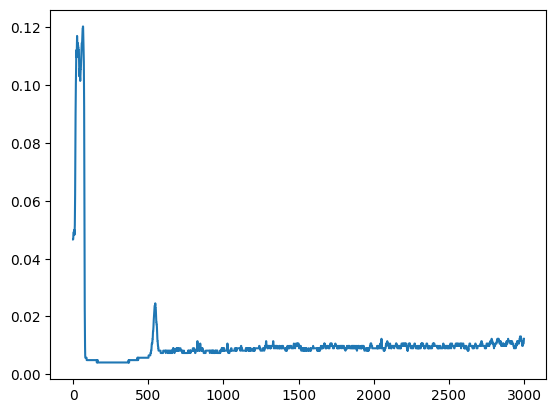

In [90]:
plt.plot(img_normalized[:, 200])

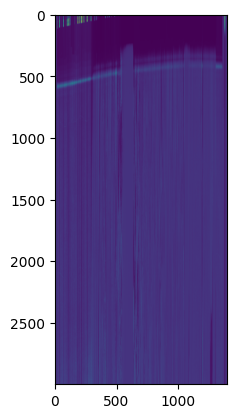

In [89]:
x_local, y_local = hipp.kh9pc.lines_processing.detect_peaks_in_columns(img_normalized, distance=200, prominence=0.2, height=None, width=30)

plt.imshow(img_normalized)
plt.scatter(x_local, y_local)
plt.show()